In [1]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
sys.path.append(r"./ewtpy")
import pandas as pd
import numpy as np
import ewtpy
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [2]:
def iewt1d(ewt,mfb):
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

## 加载数据

In [5]:
df = pd.read_csv(r"./data/combined_trace_noIO.csv", index_col=0)
TARGET = "assigned memory usage"
df = df[[TARGET]]
cols = [TARGET]
# ETW分量数量
N = 3
df.head()

,assigned memory usage
start time,
600000000,3415.579234
900000000,3423.313001
1200000000,3401.148691
1500000000,3447.942116
1800000000,3402.758848


## ewt

In [6]:
def ewt(df, N = 3, detect = "locmax", reg = 'none', lengthFilter = 0, sigmaFilter = 0, Fs = 1):
     #number of supports
     #detection mode: locmax, locmaxmin, locmaxminf
     #spectrum regularization - it is smoothed with an average (or gaussian) filter 
     #length or average or gaussian filter
     #sigma of gaussian filter
     #sampling frequency, in Hz (if unknown, set 1)
    ewt_dict, mfb_dict, boundaries_dict = {}, {}, {}
    for col in cols:
        ewt, mfb, boundaries = ewtpy.EWT1D(df[col], 
                                            N = N,
                                            log = 0,
                                            detect = detect, 
                                            completion = 0, 
                                            reg = reg, 
                                            lengthFilter = lengthFilter,
                                            sigmaFilter = sigmaFilter)
        df[[f"{col}{i}" for i in range(N)]] = ewt
        df[[f"{col}{i}_mfb" for i in range(N)]] = mfb
        ewt_dict[col]=ewt; mfb_dict[col]=mfb; boundaries_dict[col]=boundaries
    return df, ewt_dict, mfb_dict

In [7]:
df, ewt_dict, mfb_dict = ewt(df, N=N)

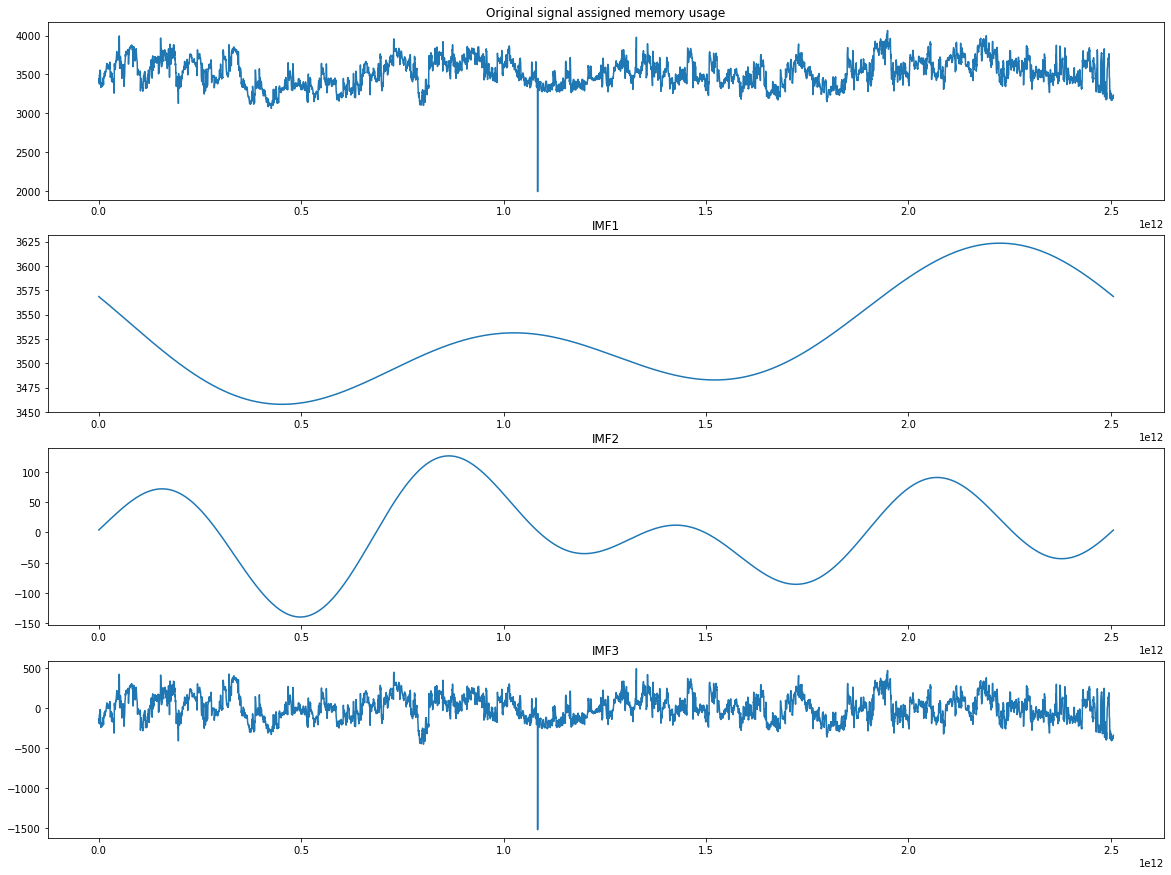

In [8]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(df[col])
    _ = plt.title('Original signal %s'%col);
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(df[f"{col}{i}"])
        _ = plt.title(f'IMF{i+1}');

In [9]:
fig.savefig(f"./savefig/{TARGET}_0.png")

## iforest

In [10]:
# 模型训练
iforest = IsolationForest(n_estimators=100, max_samples='auto',  
                          contamination=0.05, max_features=1,  
                          bootstrap=False, n_jobs=-1, random_state=1)

In [11]:
# -1为异常，1为正常
iforest_dict = {}
for col in cols:
    for i in range(1, N):
        X = df[f"{col}{i}"].values.reshape(-1, 1)
        iforest = iforest.fit(X)
        iforest_dict[f"{col}{i}"] = iforest
        df[f"{col}{i}_label"] = iforest.predict(X) 

        # 预测 decision_function 可以得出 异常评分
        # df[f"{col}{i}_scores"] = iforest.decision_function(X) 

In [12]:
# import plotly.express as px
# for col in cols:
#     for i in range(1, N):
#         tmp_df = df.copy()
#         tmp_df[f'{col}{i}_anomaly'] = tmp_df[f'{col}{i}_label'].apply(lambda x: 'outlier' if x==-1  else 'inlier') 
#         fig = px.histogram(tmp_df,x=f"{col}{i}_scores",color=f'{col}{i}_anomaly')
#         fig.show()

## 插值

In [13]:
for col in cols:
    for i in range(1, N):
        df[f"{col}{i}"] = np.where(df[f"{col}{i}_label"]==1, df[f"{col}{i}"], np.nan)

In [14]:
df = df.interpolate(axis=0)
df = df.fillna(method="bfill")
df = df.drop(columns=df.columns[df.columns.str.contains("label")])

In [15]:
df

,assigned memory usage,assigned memory usage0,assigned memory usage1,assigned memory usage2,assigned memory usage0_mfb,assigned memory usage1_mfb,assigned memory usage2_mfb
start time,,,,,,,
600000000,3415.579234,3568.505772,4.114919,-164.808972,1.000000,0.000000,0.000000
900000000,3423.313001,3568.403518,4.301215,-155.535047,1.000000,0.000000,0.000000
1200000000,3401.148691,3568.301218,4.487628,-179.572056,0.707107,0.707107,0.000000
1500000000,3447.942116,3568.198872,4.674157,-130.663498,0.000000,0.999952,0.009787
1800000000,3402.758848,3568.096479,4.860799,-178.166113,0.000000,0.707107,0.707107
...,...,...,...,...,...,...,...
2504700000000,3212.656188,3569.016338,3.185262,-237.472171,0.000000,0.009787,0.999952
2505000000000,3194.628512,3568.914319,3.370944,-237.472171,0.000000,0.707107,0.707107
2505300000000,3222.579756,3568.812252,3.556752,-237.472171,0.000000,0.999952,0.009787


In [16]:
df.to_csv(f"./data/{TARGET}.csv")